TODO
- 波动相关 feature 根据 TR 做标准化


# Init

In [1]:
from analysis_utils import get_combined_data
from plot import PricePlot
from utils import *

import pandas as pd
import numpy as np
from enum import Enum, auto
from typing import Dict, Optional, List, Set, TypeVar, Generic, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

pd.set_option('display.max_columns', None)

<Figure size 1000x500 with 0 Axes>

In [2]:
usd_name = 'BUSD'
token_name='BTC'
symbol = token_name + usd_name

full_data = get_combined_data(symbol, 'default', 1652229060000, 1658229059999)

# Basic Functions

In [3]:
def drop_col(df: pd.DataFrame, name):
    df.drop(name, axis=1, inplace=True)

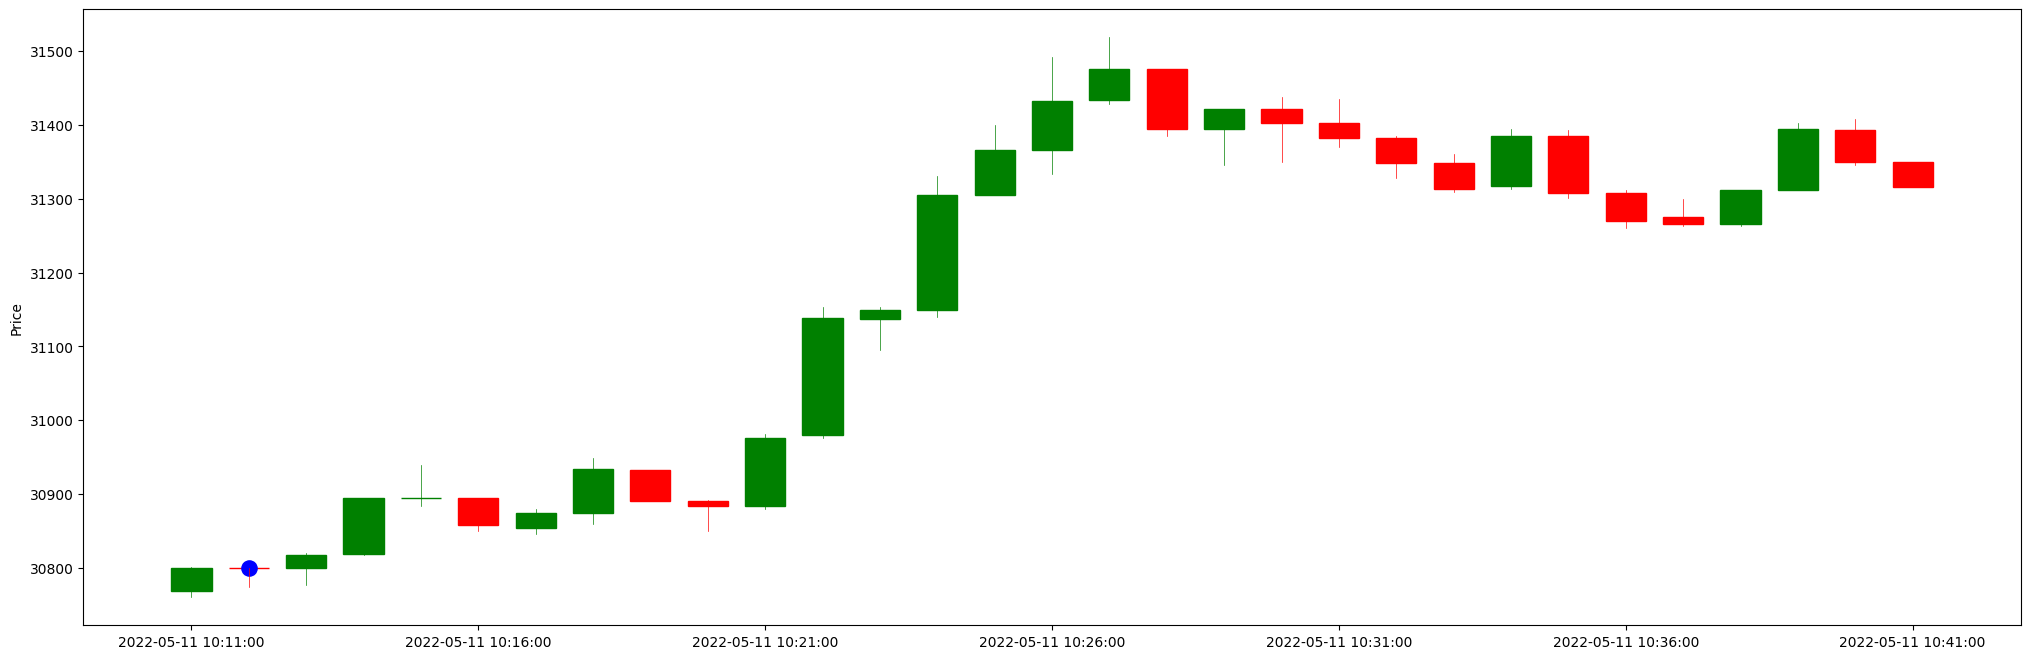

In [4]:
def plot(df: pd.DataFrame, start, end, points=[]):
    plot_df = df.loc[start:end, :]
    fig = PricePlot(plot_df['open'], plot_df['high'], plot_df['low'], plot_df['close'], 
            plot_df['open_time'].map(milliseconds_to_date))
    
    for p in points:
        p.idx -= start
        
    fig.plot(points=points, fig=plt.figure(figsize=(25, 8)))

points = [PricePlot.Points(101, full_data.loc[101, 'high'], s=120, c='b', label='high')]
plot(full_data, 100, 130, points)

## Add targets

In [5]:
class Target:
    def __init__(self, target_step = 300, steps = [1, 3, 5, 10, 30, 100, 300]):
        self.target_step = target_step
        self.steps = steps
    
    def reset_target(self, target_step):
        self.target_step = target_step

    def name(self, step: int) -> str:
        return 'earn_after_{}'.format(step)

    def target_name(self):
        return self.name(self.target_step)
    
    def other_names(self):
        return [self.name(s) for s in self.steps if s != self.target_step]
    
    # Inplace
    def add_earns(self, data: pd.DataFrame):
        for step in self.steps:
            data['close_after_{}'.format(step)] = data['close'].shift(-step)
            data[self.name(step)] = (data['close'].shift(-step) - data['close']) / data['close']
            data.drop('close_after_{}'.format(step), axis=1, inplace=True)
        
        return df

    # Inplace
    def drop_others(self, data: pd.DataFrame):
        data.drop(self.other_names(), axis=1, inplace=True)

target = Target(300, [1, 3, 5, 10, 30, 100, 300])
df = full_data.copy()
df = target.add_earns(full_data)
print(target.target_name())
print(target.other_names())
df.head(10)

earn_after_300
['earn_after_1', 'earn_after_3', 'earn_after_5', 'earn_after_10', 'earn_after_30', 'earn_after_100']


,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,buy_price,sell_price
0,1.652229e+12,31144.3,31165.8,31120.6,31164.2,30.906,1.652229e+12,9.624098e+05,501.0,18.305,569922.0360,45.2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,1.652229e+12,31164.2,31180.0,31130.4,31146.7,27.177,1.652229e+12,8.468196e+05,427.0,10.484,326626.2207,49.6,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,1.652229e+12,31140.6,31140.6,31100.0,31115.6,28.883,1.652229e+12,8.986365e+05,500.0,13.884,431899.1317,40.6,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1.652229e+12,31115.6,31154.9,31112.3,31125.0,19.850,1.652229e+12,6.179290e+05,398.0,9.091,282989.0656,42.6,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,1.652229e+12,31123.2,31148.8,31117.9,31143.8,17.293,1.652229e+12,5.383497e+05,240.0,9.574,298012.8705,30.9,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,1.652229e+12,31143.8,31173.2,31140.1,31166.2,28.494,1.652229e+12,8.879296e+05,405.0,14.910,464567.9094,33.1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
6,1.652229e+12,31161.7,31178.0,31097.8,31113.0,31.265,1.652229e+12,9.733273e+05,501.0,15.006,467108.2783,80.2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7,1.652229e+12,31113.7,31149.9,31103.6,31126.9,25.903,1.652230e+12,8.063249e+05,387.0,12.571,391250.2274,46.3,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
8,1.652230e+12,31126.8,31133.1,31093.6,31093.8,19.994,1.652230e+12,6.220328e+05,363.0,8.712,271004.6069,39.5,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9,1.652230e+12,31094.4,31096.6,31058.2,31085.3,44.620,1.652230e+12,1.386531e+06,611.0,24.789,770227.8573,38.4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


## Data wrapper

In [6]:
class FeatTypes(Enum):
    PRICE     = 'close'
    VOLUME    = 'quote_assert_volume'
    TRADE_NUM = 'number_of_trades'
    TARGET    = 'target'
    OTHERS    = 'others'

class Feat:
    def __init__(self, name: str, ftype: FeatTypes):
        self.name  = name    # 10MA
        self.ftype = ftype  # FeatTypes.PRICE
        self.stded = False

    # Standardize feature in place of the input df_data
    def std(self, df_data: pd.DataFrame):
        # Don't divide itself
        if (self.name != self.ftype.value) and (self.ftype.value in df_data.columns) and (not self.stded):
            df_data[self.name] = df_data[self.name].div(df_data[self.ftype.value], axis=0)
            self.stded = True
    
    def set_type(self, ftype: FeatTypes):
        self.ftype = ftype
        # After set neew type, refresh the stded again
        self.stded = False

    def __str__(self):
        return self.name

class Data:
    def __init__(self, data: pd.DataFrame, target: Target):
        self.df = data.copy()
        self.target = target
        self.target.add_earns(self.df)
        self.features: Dict[str, Feat] = {}
        self._init_features()

    def drop_other_targets(self):
        self.drop_features(self.target.other_names())

    def add_feature(self, name, ftype, fun: Callable[[pd.DataFrame], pd.Series]):
        self.features[name] = Feat(name, ftype)
        self.df[name] = fun(self.df)

    # One type for all names
    def add_features(self, names, ftypes, fun: Callable[[pd.DataFrame], pd.DataFrame]):
        assert(len(names) == len(ftypes))
        for i in range(len(names)):
            self.features[names[i]] = Feat(names[i], ftypes[i])
        self.df[names] = fun(self.df)

    def add_ave_feature(self, new_name, base_name, ftype, cycles):
        for cc in cycles:
            name = new_name + str(cc)
            self.add_feature(name, ftype, lambda df: df[base_name].rolling(cc).mean())
            
            # k_name = name + '_k'
            # self.add_feature(k_name, ftype, lambda df: df[name] - df[name].shift(1))

    # Features should have one type
    def set_features_type(self, names: List[str], ftype: FeatTypes):
        for na in names:
            self.features[na].set_type(ftype)

    def drop_features(self, names: List[str]):
        self.df.drop(names, axis=1, inplace=True)
        for na in names:
            del self.features[na] 

    def std(self):
        for name in self.features:
            self.features[name].std(self.df)
        
        base_features = [x.value for x in list(FeatTypes) if x.value in self.df]
        self.drop_features(base_features)

    def drop_na(self):
        self.df.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.df.dropna(axis=0, how='any', inplace=True)

    def price_cols(self):
        return self.features

    def _init_features(self):
        exist_feats = [ 
            [['open', 'high', 'low', 'close', 'last_top', 'last_bottom', 'TR', 'buy_price', 'sell_price'], FeatTypes.PRICE],
            [['number_of_trades'], FeatTypes.TRADE_NUM],
            [['quote_assert_volume', 'taker_buy_quote_asset_volume'], FeatTypes.VOLUME],
            [[self.target.target_name()] + self.target.other_names(), FeatTypes.TARGET]
            ]

        for feats_type in exist_feats:
            feats, ftype = feats_type
            for f in feats:
                self.features[f] = Feat(f, ftype)

        for col in self.df.columns:
            if col not in self.features.keys():
                self.features[col] = Feat(col, FeatTypes.OTHERS)

target = Target(300, [1, 3, 5, 10, 30, 100, 300])
data = Data(full_data, target)
print(data.target.target_name())
print(data.target.other_names())

earn_after_300
['earn_after_1', 'earn_after_3', 'earn_after_5', 'earn_after_10', 'earn_after_30', 'earn_after_100']


## 画图函数

In [7]:
# 画数据分布图
def histplot(pred, truth=None, xlim=None):
    plt.figure(figsize=(12,5))
    sns.histplot(pred, kde=True, color="blue")
    if truth is not None:
        sns.histplot(truth, kde=True, color="red")
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()

# 画 B 相对于 A 的分布图，会把 A 等量分箱 50 份
def plt_A_B(df_data: pd.DataFrame, idx_A, idx_B, bias=0.0, cut=True, cut_num=50):
    plt.figure(figsize=(18,5))

    if cut:
        df_data[idx_A + '_cut'] = pd.qcut(df_data[idx_A], cut_num, duplicates='drop')
        idx_A = idx_A + '_cut'
        
    (df_data.groupby(idx_A)[idx_B].mean() - bias).plot.bar()
    plt.title(idx_B)
    plt.show()

    if cut:
        df_data.drop(idx_A, axis=1, inplace=True)

def plt_point_A_B(df_data, idx_A, idx_B):
    df_data.plot(kind='scatter', x=idx_A, y=idx_B, figsize=(18,5))

# 画 B 相对于 A 的分箱图，会把 A 等量分箱 50 份
def plt_box_A_B(df_data, idx_A, idx_B, cut=True, cut_num=50):
    plt.figure(figsize=(18,5))

    if cut:
        df_data[idx_A + '_cut'] = pd.qcut(df_data[idx_A], cut_num, duplicates='drop')
        idx_A = idx_A + '_cut'

    sns.boxplot(x=idx_A, y=idx_B, data=df_data)
    sns.stripplot(x=idx_A, y=idx_B, data=df_data)
    plt.title(idx_B)
    plt.show()

    if cut:
        df_data.drop(idx_A, axis=1, inplace=True)


def heatmap(pd_data):
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(corrmat, vmax=.8, square=True)

def heatmap_font(pd_data, target, k=-1):
    # k is the number of variables for heatmap
    if k == -1:
        k = pd_data.shape[1]
        
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(20, 16))
    cols = corrmat.nlargest(k, target)[target].index
    cm = np.corrcoef(pd_data[cols].values.T)
    sns.set(font_scale=1.25) # type: ignore
    hm = sns.heatmap(cm,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 8}, 
                     yticklabels=cols.values,
                     xticklabels=cols.values)
    plt.show()

# histplot(df[target.target_name()])
# th = 0.03
# print((sum(df[target.target_name()] > th) + sum(df[target.target_name()] < -th)) / len(df))

## Add average features

In [8]:
def add_ave_features(data: Data, cycles = [3, 5, 10, 30, 100, 300], feat_names=['close', 'TR']):
    new_ave_of_base = {
        'MA': ['close', FeatTypes.PRICE],
        'ATR': ['TR', FeatTypes.PRICE],
        'AQAV': ['quote_assert_volume', FeatTypes.VOLUME],
        'AT': ['number_of_trades', FeatTypes.TRADE_NUM],
        'ATBQAV': ['taker_buy_quote_asset_volume', FeatTypes.VOLUME],
        'ACS': ['cycle_step', FeatTypes.OTHERS]
        }

    for new_name in new_ave_of_base:  
        [base, ftype] = new_ave_of_base[new_name]
        if base in feat_names:
            data.add_ave_feature(new_name, base, ftype, cycles)

data = Data(df, target)
add_ave_features(data)
print([(x.name, x.ftype.value) for x in data.features.values()])
data.df.tail(10)

[('open', 'close'), ('high', 'close'), ('low', 'close'), ('close', 'close'), ('last_top', 'close'), ('last_bottom', 'close'), ('TR', 'close'), ('buy_price', 'close'), ('sell_price', 'close'), ('number_of_trades', 'number_of_trades'), ('quote_assert_volume', 'quote_assert_volume'), ('taker_buy_quote_asset_volume', 'quote_assert_volume'), ('earn_after_300', 'target'), ('earn_after_1', 'target'), ('earn_after_3', 'target'), ('earn_after_5', 'target'), ('earn_after_10', 'target'), ('earn_after_30', 'target'), ('earn_after_100', 'target'), ('open_time', 'others'), ('volume', 'others'), ('close_time', 'others'), ('taker_buy_volume', 'others'), ('step_after_top', 'others'), ('step_after_bottom', 'others'), ('is_up', 'others'), ('cycle_step', 'others'), ('MA3', 'close'), ('MA5', 'close'), ('MA10', 'close'), ('MA30', 'close'), ('MA100', 'close'), ('MA300', 'close'), ('ATR3', 'close'), ('ATR5', 'close'), ('ATR10', 'close'), ('ATR30', 'close'), ('ATR100', 'close'), ('ATR300', 'close')]


,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,buy_price,sell_price,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA3,MA5,MA10,MA30,MA100,MA300,ATR3,ATR5,ATR10,ATR30,ATR100,ATR300
99990,1.658228e+12,22000.1,22007.8,21977.8,21977.8,43.355,1.658229e+12,9.536830e+05,510.0,13.841,3.045368e+05,30.0,21953.4,98.0,21809.3,42.0,1.0,56.0,21977.8,NaN,-0.000419,0.000437,0.001101,NaN,NaN,NaN,NaN,21991.233333,21994.30,21992.32,21974.646667,21914.842,21868.426000,19.833333,22.60,32.23,32.933333,27.005,30.692667
99991,1.658229e+12,21977.9,21992.1,21968.5,21968.6,51.141,1.658229e+12,1.124041e+06,575.0,13.711,3.013761e+05,23.6,21953.4,99.0,21809.3,43.0,1.0,56.0,21968.5,NaN,0.000901,0.000178,0.002454,NaN,NaN,NaN,NaN,21982.133333,21988.00,21987.67,21978.426667,21915.369,21868.258000,21.933333,19.96,31.55,33.560000,26.492,30.704333
99992,1.658229e+12,21968.6,21994.0,21968.6,21988.4,47.282,1.658229e+12,1.039419e+06,446.0,28.938,6.361075e+05,25.4,21953.4,100.0,21809.3,44.0,1.0,56.0,21968.6,NaN,-0.000045,0.000619,0.000864,NaN,NaN,NaN,NaN,21978.266667,21986.14,21988.40,21983.260000,21915.930,21868.144333,26.333333,21.70,29.40,33.963333,26.370,30.775667
99993,1.658229e+12,21988.5,21988.6,21979.6,21987.4,24.870,1.658229e+12,5.467337e+05,305.0,16.766,3.685595e+05,9.0,21953.4,101.0,21809.3,45.0,1.0,56.0,21979.6,NaN,-0.000678,0.001596,0.001651,NaN,NaN,NaN,NaN,21981.466667,21984.44,21991.19,21987.973333,21916.702,21868.151333,19.333333,20.04,25.84,34.173333,26.237,30.641667
99994,1.658229e+12,21987.5,21987.5,21970.4,21972.5,22.142,1.658229e+12,4.866162e+05,310.0,1.785,3.923193e+04,17.1,21953.4,102.0,21809.3,46.0,1.0,56.0,21970.4,NaN,0.001343,0.001588,0.002608,NaN,NaN,NaN,NaN,21982.766667,21978.94,21990.12,21992.160000,21917.441,21868.100667,17.166667,21.02,22.58,33.966667,26.122,30.608667
99995,1.658229e+12,21972.5,22006.9,21972.5,22002.0,48.459,1.658229e+12,1.065755e+06,526.0,31.333,6.890217e+05,34.4,21953.4,103.0,21809.3,47.0,1.0,56.0,21972.5,NaN,0.000932,0.000986,NaN,NaN,NaN,NaN,NaN,21987.300000,21983.78,21989.04,21996.746667,21918.206,21868.239333,20.166667,21.90,22.25,34.336667,26.060,30.535333
99996,1.658229e+12,22002.1,22032.9,21992.8,22022.5,79.150,1.658229e+12,1.742416e+06,797.0,55.968,1.232091e+06,40.1,21953.4,104.0,21809.3,48.0,1.0,56.0,21992.8,NaN,-0.000686,0.000331,NaN,NaN,NaN,NaN,NaN,21999.000000,21994.56,21991.28,22001.403333,21919.101,21868.560333,30.533333,25.20,22.58,35.010000,26.255,30.500333
99997,1.658229e+12,22024.0,22025.9,22000.0,22007.4,43.500,1.658229e+12,9.575751e+05,637.0,21.357,4.701970e+05,25.9,21953.4,105.0,21809.3,49.0,1.0,56.0,22000.0,NaN,0.000741,NaN,NaN,NaN,NaN,NaN,NaN,22010.633333,21998.36,21992.25,22004.723333,21920.116,21868.795667,33.466667,25.30,23.50,34.713333,26.168,30.507667
99998,1.658229e+12,22007.4,22034.8,22007.3,22023.7,55.508,1.658229e+12,1.222201e+06,573.0,41.976,9.241529e+05,27.5,21953.4,106.0,21809.3,50.0,1.0,56.0,22007.3,NaN,0.000277,NaN,NaN,NaN,NaN,NaN,NaN,22017.866667,22005.62,21995.03,22007.970000,21921.274,21869.111000,31.166667,29.00,24.52,33.930000,26.357,30.567667
99999,1.658229e+12,22023.7,22030.1,22023.7,22029.8,15.744,1.658229e+12,3.468109e+05,250.0,10.674,2.351284e+05,6.4,21953.4,107.0,21809.3,51.0,1.0,56.0,22023.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22020.300000,22017.08,21998.01,22010.896667,21922.633,21869.543667,19.933333,26.86,23.94,33.613333,26.245,30.484667


## Add MACD

In [9]:
def add_macd(data: Data, base='close', ftype=FeatTypes.PRICE, fast_period=12, slow_period=26, signal_period=9):
    """
    计算 MACD

    :param df: pandas.DataFrame 包含价格数据
    :param fast_period: int 快线周期, 默认为12
    :param slow_period: int 慢线周期, 默认为26
    :param signal_period: int 信号线周期, 默认为9
    :return: pandas.DataFrame 包含 MACD、Signal 和 Histogram
    """

    # 计算快线、慢线和差离值
    data.add_feature('EMA_fast_'+base, ftype, lambda df: df[base].ewm(span=fast_period).mean())
    data.add_feature('EMA_slow_'+base, ftype, lambda df: df[base].ewm(span=slow_period).mean())
    data.add_feature('MACD_'+base, ftype, lambda df: df['EMA_fast_'+base] - df['EMA_slow_'+base])

    # 计算信号线和 MACD 柱状图
    data.add_feature('signal_'+base, ftype, lambda df: df['MACD_'+base].ewm(span=signal_period).mean())
    data.add_feature('histogram_'+base, ftype, lambda df: df['MACD_'+base] - df['signal_'+base])

    data.drop_features(['EMA_fast_'+base, 'EMA_slow_'+base])

data = Data(df, target)
add_macd(data)
add_macd(data, 'TR')
data.df.tail()

,open_time,open,high,low,close,volume,close_time,quote_assert_volume,number_of_trades,taker_buy_volume,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,buy_price,sell_price,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MACD_close,signal_close,histogram_close,MACD_TR,signal_TR,histogram_TR
99995,1.658229e+12,21972.5,22006.9,21972.5,22002.0,48.459,1.658229e+12,1.065755e+06,526.0,31.333,6.890217e+05,34.4,21953.4,103.0,21809.3,47.0,1.0,56.0,21972.5,NaN,0.000932,0.000986,NaN,NaN,NaN,NaN,NaN,7.582811,13.740361,-6.157550,-3.122446,-1.914801,-1.207646
99996,1.658229e+12,22002.1,22032.9,21992.8,22022.5,79.150,1.658229e+12,1.742416e+06,797.0,55.968,1.232091e+06,40.1,21953.4,104.0,21809.3,48.0,1.0,56.0,21992.8,NaN,-0.000686,0.000331,NaN,NaN,NaN,NaN,NaN,9.560316,12.904352,-3.344036,-1.754661,-1.882773,0.128112
99997,1.658229e+12,22024.0,22025.9,22000.0,22007.4,43.500,1.658229e+12,9.575751e+05,637.0,21.357,4.701970e+05,25.9,21953.4,105.0,21809.3,49.0,1.0,56.0,22000.0,NaN,0.000741,NaN,NaN,NaN,NaN,NaN,NaN,9.796135,12.282709,-2.486573,-1.795802,-1.865379,0.069577
99998,1.658229e+12,22007.4,22034.8,22007.3,22023.7,55.508,1.658229e+12,1.222201e+06,573.0,41.976,9.241529e+05,27.5,21953.4,106.0,21809.3,50.0,1.0,56.0,22007.3,NaN,0.000277,NaN,NaN,NaN,NaN,NaN,NaN,11.169542,12.060075,-0.890533,-1.679934,-1.828290,0.148355
99999,1.658229e+12,22023.7,22030.1,22023.7,22029.8,15.744,1.658229e+12,3.468109e+05,250.0,10.674,2.351284e+05,6.4,21953.4,107.0,21809.3,51.0,1.0,56.0,22023.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.604895,12.169039,0.435856,-3.253201,-2.113272,-1.139929


## 后续一段时间最大最小值

In [10]:
# 增加一段时间后的最大值与最小值以及索引
# 如 1,5,3,2，window 为 3，则从 1 开始的三个最大值是 5，索引为0，最小值为2，索引为2
def calc_max_min_window(df: pd.DataFrame, window):
    highs = []
    lows = []
    def calc_max_min(x):
        if len(highs) < window-1:
            highs.append(x['high'])
            lows.append(x['low'])
            max_value = np.nan
            min_value = np.nan
            max_index = np.nan
            min_index = np.nan            

        else:
            highs.append(x['high'])
            lows.append(x['low'])

            max_value = max(highs)
            min_value = min(lows)
            max_index = highs.index(max_value)
            min_index = lows.index(min_value)
            
            highs.pop(0)
            lows.pop(0)

        return pd.Series([max_value, min_value, max_index, min_index])
        
    # df[[max_win, min_win, imax_win, imin_win]] = \
    return df.apply(calc_max_min, axis=1, result_type="expand").shift(-window)

# 将结果合并到原始 DataFrame 中
# df[['max', 'max_index', 'min', 'min_index']] = result
 # 示例数据
test_data = {'high': [1, 5, 3, 2, 3, 5], 'low': [1, 5, 3, 2, 3, 5]}
test_df = pd.DataFrame(test_data)
print(test_df)
print(calc_max_min_window(test_df, 3))
# test_df

   high  low
0     1    1
1     5    5
2     3    3
3     2    2
4     3    3
5     5    5
     0    1    2    3
0  5.0  2.0  0.0  2.0
1  3.0  2.0  0.0  1.0
2  5.0  2.0  2.0  0.0
3  NaN  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN
5  NaN  NaN  NaN  NaN


In [11]:
def add_window_feature(data: Data, window):
    names = [f'max_after_{window}', f'min_after_{window}', f'imax_after_{window}', f'imin_after_{window}']
    ftypes = [FeatTypes.PRICE, FeatTypes.PRICE, FeatTypes.OTHERS, FeatTypes.OTHERS]
    data.add_features(names, ftypes, lambda df: calc_max_min_window(df, window))
    return names

# data = Data(df, Target(300, [10, 300]))
# add_window_feature(data, 3)
# data.df.tail()

## 数据观测

In [12]:
# 显示数据缺失率，最大类别占比
def show_data_basic_info(pd_data, sort_target = 'Percentage of missing values'):
    stats = []
    for col in pd_data.columns:
        stats.append((col,
                      pd_data[col].nunique(),
                      pd_data[col].isnull().sum(),
                      pd_data[col].isnull().sum() * 100 / pd_data.shape[0],
                      pd_data[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                      pd_data[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feat',
                                            'Unique_values',
                                            'missing number',
                                            'Percentage of missing values',
                                            'Percentage of values in the biggest category',
                                            'type'])
    
    return stats_df.sort_values(sort_target, ascending=False)

show_data_basic_info(data.df)[:10]

,Feat,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
18,buy_price,13011,80807,80.807,80.807,float64
19,sell_price,15433,77655,77.655,77.655,float64
26,earn_after_300,99640,300,0.300,0.300,float64
12,last_top,1248,146,0.146,0.462,float64
17,cycle_step,156,146,0.146,2.641,float64
13,step_after_top,350,146,0.146,1.302,float64
15,step_after_bottom,345,123,0.123,1.296,float64
14,last_bottom,1260,123,0.123,0.345,float64
25,earn_after_100,99808,100,0.100,0.100,float64
24,earn_after_30,99841,30,0.030,0.051,float64


## Standardization

In [13]:
data = Data(df, target)
add_ave_features(data)
data.drop_features(['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])
data.std()
data.drop_na()
show_data_basic_info(data.df)[:10]
data.df.head()

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA3,MA5,MA10,MA30,MA100,MA300,ATR3,ATR5,ATR10,ATR30,ATR100,ATR300
299,1.000928,1.001432,1.000000,0.285093,0.001432,1.002898,147.0,0.983324,42.0,1.0,105.0,-0.000060,0.003174,0.001039,-0.003307,-0.004827,-0.036750,0.003456,1.001148,1.001606,1.000815,0.996708,0.990916,0.987267,0.001798,0.002152,0.001942,0.002792,0.001813,0.001708
300,1.000060,1.000627,0.999338,0.272918,0.001289,1.002958,148.0,0.983383,43.0,1.0,105.0,0.002936,0.000329,-0.000124,-0.002477,-0.004960,-0.038007,0.005344,1.000351,1.001337,1.000770,0.997212,0.991084,0.987370,0.001788,0.001811,0.001777,0.002796,0.001813,0.001708
301,0.997072,1.000104,0.997072,0.748669,0.003032,1.000022,149.0,0.980504,44.0,1.0,105.0,0.000297,-0.001832,-0.003904,-0.005988,-0.007911,-0.038558,0.002823,0.998068,0.998380,0.998129,0.994844,0.988322,0.984533,0.001915,0.001939,0.001877,0.002877,0.001830,0.001707
302,0.999703,1.001452,0.999378,0.670154,0.002074,0.999725,150.0,0.980213,45.0,1.0,105.0,-0.002895,-0.003347,-0.005955,-0.005459,-0.008749,-0.038323,0.003871,0.998827,0.998216,0.998107,0.995103,0.988189,0.984300,0.002130,0.002090,0.001958,0.002914,0.001826,0.001710
303,1.002904,1.002907,0.999873,0.311502,0.003033,1.002628,151.0,0.983060,46.0,1.0,105.0,0.000769,-0.001308,-0.002270,-0.003008,-0.003749,-0.036240,0.005519,1.001837,1.000982,1.001104,0.998500,0.991193,0.987206,0.002718,0.002175,0.002111,0.002953,0.001849,0.001720


# 观察特征

## 与未来波动范围 Range 的相关性
（当前 TR 是绝对值，及波动率，可能有问题）

In [14]:
data_range = Data(df, Target(300, [1, 3, 5, 10, 30, 100, 300]))
add_ave_features(data_range)
data_range.drop_features(['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])
data_range.std()
data_range.add_feature('ATR300-3', FeatTypes.PRICE, lambda df: df["ATR300"] - df["ATR3"])
data_range.add_feature('range', FeatTypes.PRICE, lambda df: df[target.target_name()].apply(lambda x: x if x > 0 else -x))
data_range.drop_other_targets()
data_range.drop_na()

# heatmap_font(data_range.df, target="range")

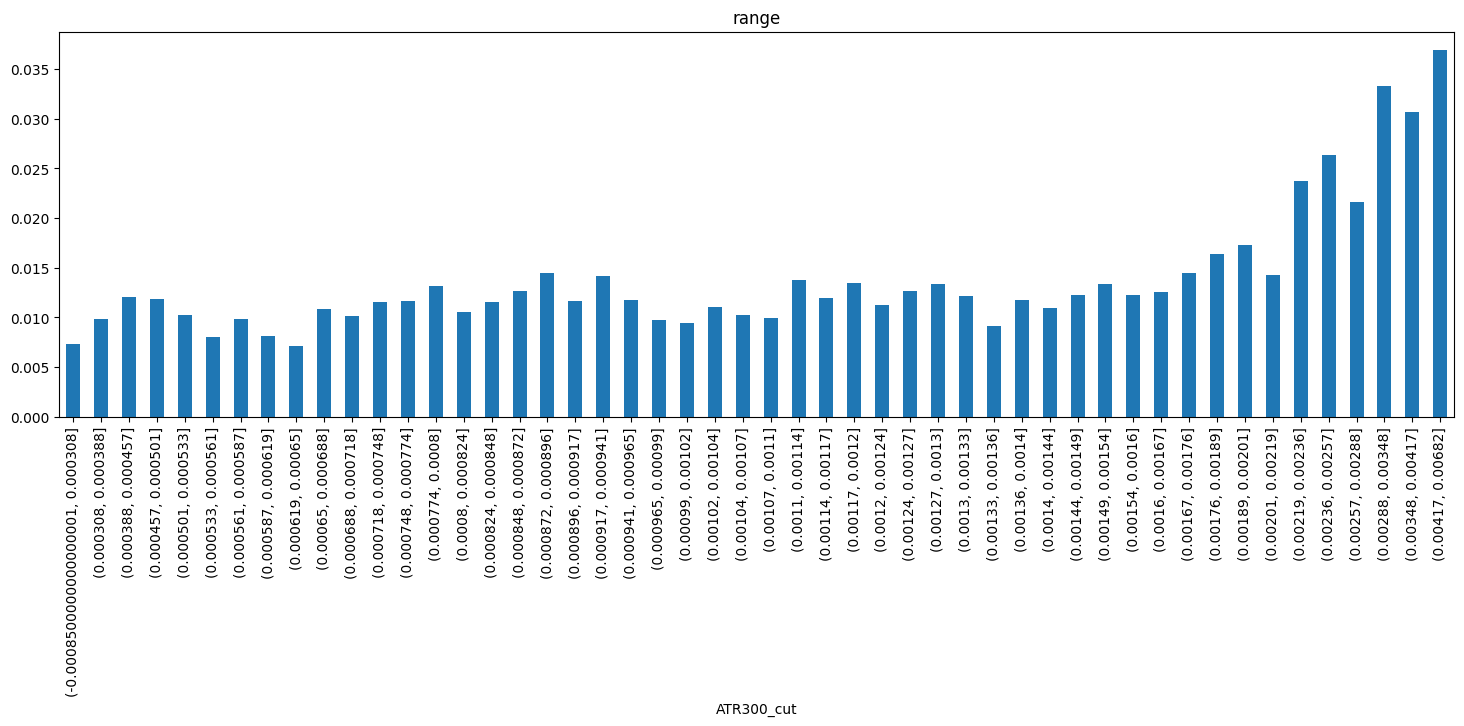

In [15]:
plt_A_B(data_range.df, "ATR300", "range")
# plt_box_A_B(data_range.df, "ATR300", "range")

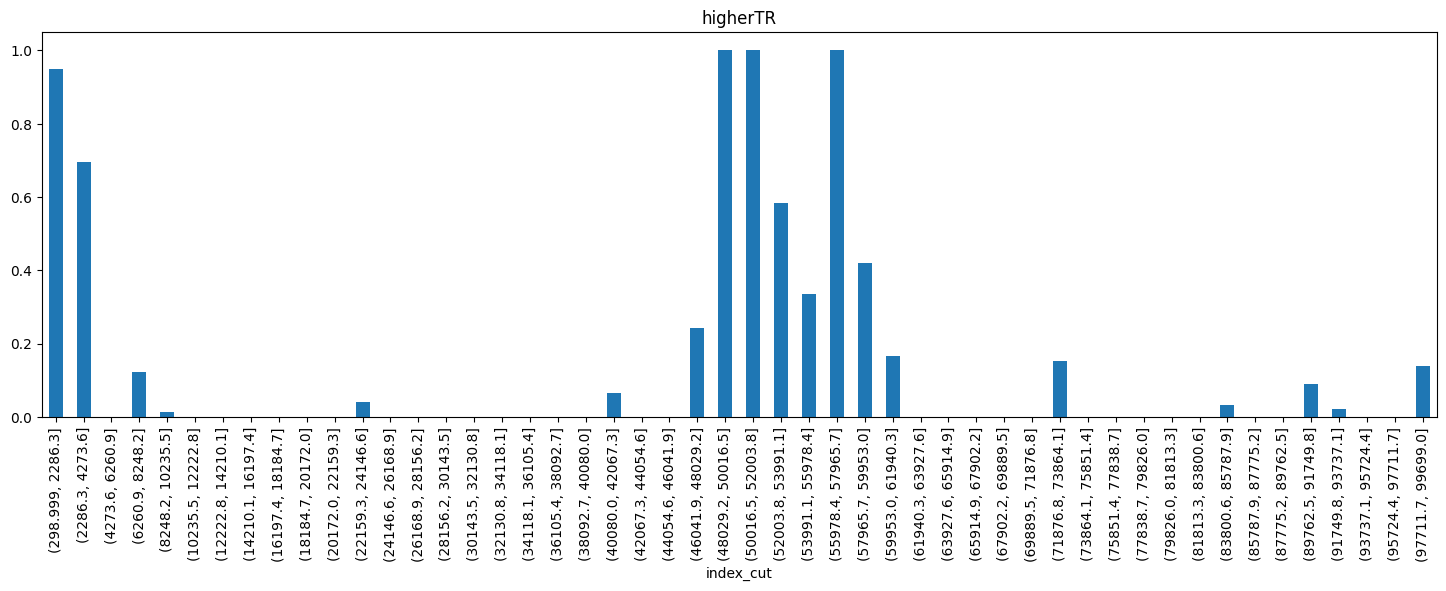

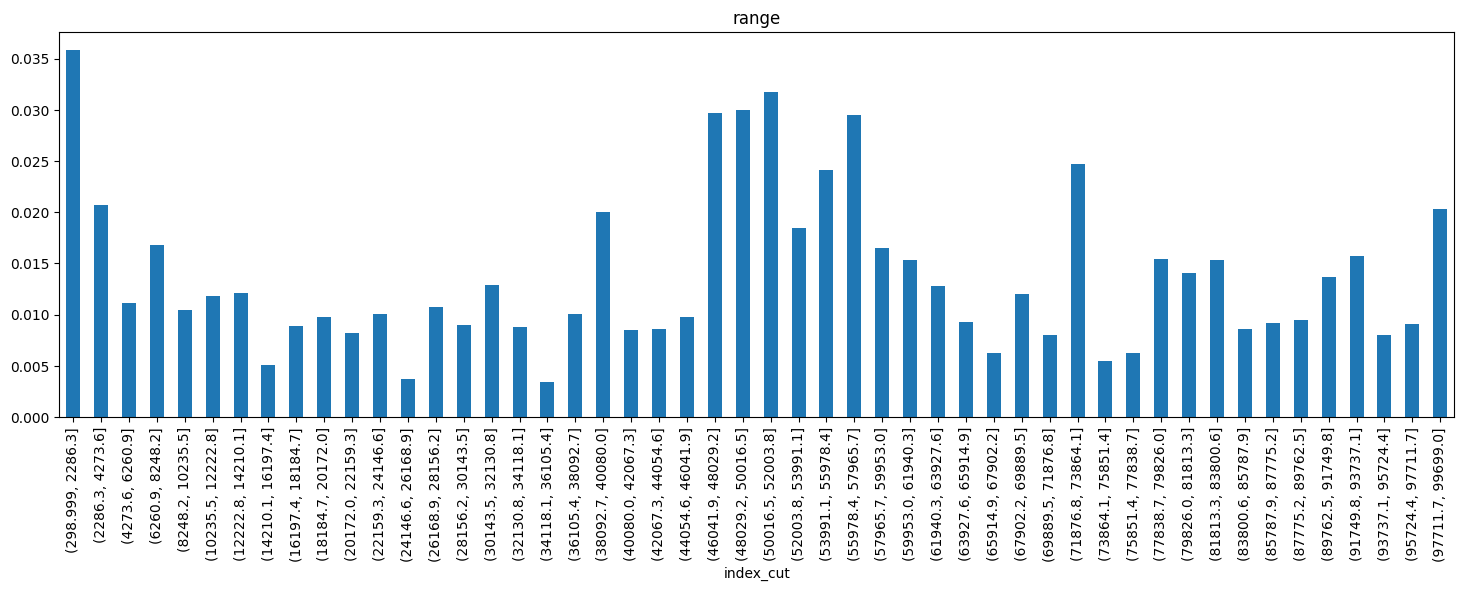

In [16]:
# full_buy[full_buy['high'] > 1.003].shape
data_range.add_feature('index', FeatTypes.OTHERS, lambda df: df.index) # type: ignore
data_range.add_feature('higherTR', FeatTypes.OTHERS, lambda df: 
                       (df['ATR300'] > 0.002).apply(lambda x : 1 if x else 0))

plt_A_B(data_range.df, "index", "higherTR")
plt_A_B(data_range.df, "index", "range")

## 达到上一顶（底）价格后短期走势

In [17]:
data_top_bottom = Data(df, target)

# Drop useless features
data_top_bottom.drop_features(
   ['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])

# Drop non price features
all_features = data_top_bottom.features
vol_cols = [col for col in data_top_bottom.df.columns 
                 if col in all_features and all_features[col].ftype == FeatTypes.VOLUME]
trade_num_cols = [col for col in data_top_bottom.df.columns 
                 if col in all_features and all_features[col].ftype == FeatTypes.TRADE_NUM]

# Add features
add_ave_features(data_top_bottom, cycles = [10, 300], feat_names=['close', 'TR'])
add_macd(data_top_bottom)
add_macd(data_top_bottom, 'TR')

data_top_bottom.drop_features(vol_cols + trade_num_cols)

# Select first buy data.
# Note this must after drop non price features (or this feature will be droped) 
# and before drop na (or nan buy_price will be droped)
last_point_traded = False
last_point = 0

def get_first_break(x: pd.DataFrame, point='last_top'):
   global last_point_traded, last_point
   is_traded = False
   if x[point] != last_point:
      last_point = x[point]
      last_point_traded = False
   
   if (last_point_traded == False and 
       (('top' in point and x['high'] >= last_point) or 
        ('bottom' in point and x['low'] <= last_point))
   ):
      is_traded = True
      last_point_traded = True
   
   return is_traded
   
data_top_bottom.add_feature('first_buy', FeatTypes.OTHERS, lambda df: 
                           df.apply(lambda x: get_first_break(x, 'last_top'), axis=1))

data_top_bottom.add_feature('first_sell', FeatTypes.OTHERS, lambda df: 
                           df.apply(lambda x: get_first_break(x, 'last_bottom'), axis=1))

# Add max and min in 10 steps and max_first
window = 10
max_win, min_win, imax_win, imin_win = add_window_feature(data_top_bottom, window)

# Standardization
data_top_bottom.std()

# Drop na at last
data_top_bottom.drop_na()

buy_break_data = data_top_bottom.df[data_top_bottom.df['first_buy']].copy()
drop_col(buy_break_data, ['first_buy', 'first_sell'])

sell_break_data = data_top_bottom.df[data_top_bottom.df['first_sell']].copy()
drop_col(sell_break_data, ['first_buy', 'first_sell'])

sell_break_data.head()

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA10,MA300,ATR10,ATR300,MACD_close,signal_close,histogram_close,MACD_TR,signal_TR,histogram_TR,max_after_10,min_after_10,imax_after_10,imin_after_10
371,1.004622,1.004993,0.999997,0.004996,1.029207,90.0,1.002062,114.0,0.0,24.0,0.000216,-0.003283,-0.002908,-0.009270,-0.017420,-0.003689,0.019840,1.008571,1.009188,0.001852,0.001797,-0.001970,-0.001118,-0.000851,0.000399,0.000028,0.000371,1.001197,0.990688,0.0,6.0
631,1.001822,1.002198,0.999829,0.002369,1.015675,50.0,1.000035,32.0,1.0,18.0,-0.002138,-0.005821,-0.001747,0.004242,-0.001532,-0.051591,-0.018647,1.005756,0.982987,0.002406,0.002692,-0.000161,0.000656,-0.000817,-0.000014,-0.000004,-0.000009,1.005177,0.993307,9.0,2.0
684,1.000073,1.000718,0.999714,0.001004,1.013395,41.0,0.999736,50.0,0.0,9.0,0.000852,0.000703,-0.000537,0.004231,0.003671,-0.058149,-0.038924,1.001436,0.991723,0.001560,0.002781,-0.001537,-0.001313,-0.000224,-0.000198,-0.000133,-0.000065,1.005471,0.998805,9.0,4.0
938,1.006519,1.006519,0.999288,0.007231,1.043770,83.0,1.001577,118.0,0.0,35.0,-0.003686,0.001371,0.000839,-0.004038,-0.001005,-0.027617,-0.068707,1.008435,1.010612,0.004462,0.004991,-0.002700,-0.002347,-0.000353,0.000165,0.000136,0.000029,1.004045,0.994852,2.0,1.0
1124,1.002796,1.003119,0.999140,0.003979,1.018419,31.0,1.000297,77.0,0.0,46.0,0.002998,0.005119,0.002266,-0.002489,-0.012356,-0.043222,-0.010437,1.006292,1.030009,0.003379,0.004127,-0.001123,-0.000723,-0.000400,0.000042,-0.000072,0.000114,1.008697,0.995532,3.0,8.0


In [18]:
print_data = buy_break_data.iloc[:]

print(f"buy break num: {len(print_data)}")
print("Earn after buy:")
for step in target.steps:
    print(f"{step}: earn rate: {sum(print_data[target.name(step)] > 0) / len(print_data) * 100 :.2f} %, " + 
          f"mean of earn: {print_data[target.name(step)].mean() * 100 :.2f}%")

print_data = sell_break_data.iloc[:]

print()
print(f"sell break num: {len(print_data)}")
print("Earn after sell:")
for step in target.steps:
    print(f"{step}: earn rate: {sum(print_data[target.name(step)] > 0) / len(print_data) * 100 :.2f} %, " + 
          f"mean of earn: {print_data[target.name(step)].mean() * 100 :.2f}%")

buy break num: 580
Earn after buy:
1: earn rate: 47.07 %, mean of earn: 0.01%
3: earn rate: 41.21 %, mean of earn: -0.01%
5: earn rate: 43.10 %, mean of earn: -0.01%
10: earn rate: 42.93 %, mean of earn: -0.03%
30: earn rate: 45.69 %, mean of earn: -0.02%
100: earn rate: 46.55 %, mean of earn: -0.01%
300: earn rate: 46.72 %, mean of earn: -0.12%

sell break num: 587
Earn after sell:
1: earn rate: 49.06 %, mean of earn: -0.03%
3: earn rate: 50.26 %, mean of earn: -0.03%
5: earn rate: 49.40 %, mean of earn: -0.03%
10: earn rate: 52.30 %, mean of earn: -0.02%
30: earn rate: 49.23 %, mean of earn: -0.06%
100: earn rate: 50.26 %, mean of earn: -0.09%
300: earn rate: 51.62 %, mean of earn: -0.08%


### 统计突破高点后一段时间的最高、最低值

#### 概述

In [22]:
heatmap_data = buy_break_data.copy()
target_step = 10
target.reset_target(target_step)

target_name = target.target_name()
target.drop_others(heatmap_data)
drop_col(heatmap_data, [target.target_name(), imax_win, imin_win])
# heatmap_font(heatmap_data, target=max_win)
# heatmap_font(heatmap_data, target=min_win)

# histplot(buy_break_data[max_win], buy_break_data[min_win], xlim=[0.99, 1.01])
# histplot(buy_break_data[imax_win], buy_break_data[imin_win])

# sns.set()
# cols = [imax_win, imin_win, 'step_after_top','step_after_bottom']
# sns.pairplot(buy_break_data[cols], height = 2.5)
# plt.show()

# histplot(buy_break_data['earn_after_1'], xlim=[-0.005, 0.005])
# histplot(buy_break_data['earn_after_3'], xlim=[-0.005, 0.005])
# histplot(buy_break_data['earn_after_10'], xlim=[-0.005, 0.005])

# plt_A_B(buy_break_data, 'ATR10', max_win, bias=1)

# plt_A_B(buy_break_data, 'ATR10', max_win, bias=1)
# plt_A_B(buy_break_data, 'ATR10', min_win, bias=1)

#### 线性回归预测 max, min

max 和 min 的方差与 ATR10 有强烈的相关性，所以选取正常范围的 ATR 进行 max 值和 std 的预测

0.0013511181479351183
0.0012609134997883494
0.005133858647300166
0.015517241379310345


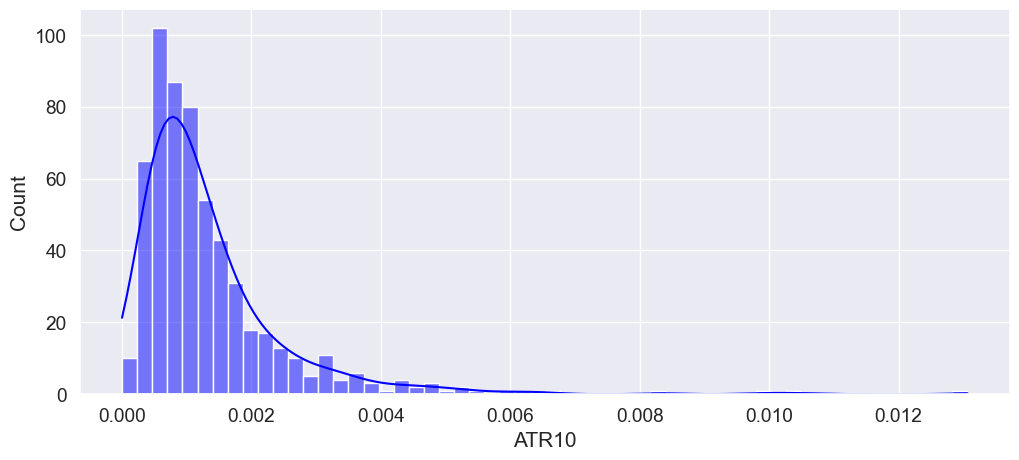

In [21]:
ATR10_mean = buy_break_data['ATR10'].mean()
ATR10_std = buy_break_data['ATR10'].std()
print(ATR10_mean)
print(ATR10_std)
print(ATR10_mean + 3*ATR10_std)
print(sum(buy_break_data['ATR10'] > ATR10_mean + 3*ATR10_std) / len(buy_break_data))

histplot(buy_break_data['ATR10'])

选择 3 $\sigma$ 内的 TR 值进行回归

max_after_10:
rmse: 0.003910848678723936
max_after_10 = 1.0011772533945595 + 1.469759527418778 * ATR10



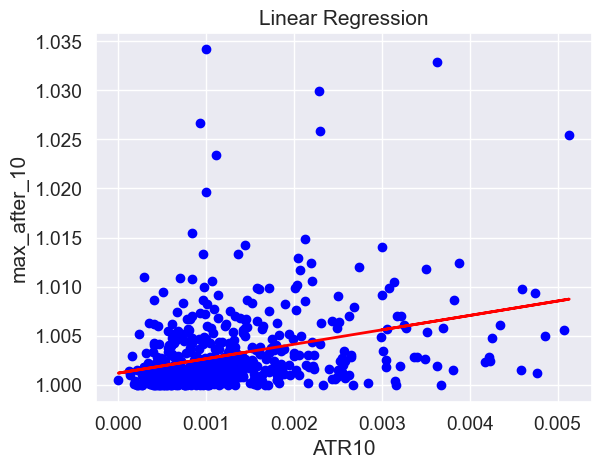

min_after_10:
rmse: 0.0024479010008921815
min_after_10 = 0.9995521675673663 + -1.6089474145113205 * ATR10



In [22]:
# 生成 X 和 Y 的随机数据
x_name = f'ATR10'
y_max_name = max_win
y_min_name = min_win

# ATR10 因为拖尾严重，所以选择 3 sigma 以内的数据。
train_data = buy_break_data[buy_break_data[x_name] < ATR10_mean + 3*ATR10_std]

# 获取 X, Y
X = train_data[x_name].values.astype(np.float64).reshape(-1, 1)

# base = train_data['last_top']     # 误差更大，所以放弃
base = 1    # 1 表示 close

Y_max = (train_data[y_max_name] / base).values.astype(np.float64)
Y_min = (train_data[y_min_name] / base).values.astype(np.float64)

def linear_regression(X, Y, x_name, y_name, plot=False):
    print(f'{y_name}:')
    # 训练线性回归模型
    model = LinearRegression()
    model.fit(X, Y)
    Y_train_pred = model.predict(X)

    # 计算均方误差
    rmse = sqrt(mean_squared_error(Y, Y_train_pred))
    print(f'rmse: {rmse}')
    print(f'{y_name} = {model.intercept_} + {model.coef_[0]} * {x_name}\n')

    if plot:
        # 绘制散点图和拟合直线
        plt.scatter(X, Y, color='blue')
        plt.plot(X, Y_train_pred, color='red', linewidth=2)
        plt.title('Linear Regression')
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.show()
    return model

model_max = linear_regression(X, Y_max, x_name, y_max_name, plot=True)
model_min = linear_regression(X, Y_min, x_name, y_min_name)

可以看到方差随着 ATR 增大而增大，所以再求一个方差与 ATR 的线性回归

In [23]:
def plot_with_dis(model, std_model, X, Y, x_name, y_name, Y_dis=None):
    # 绘制散点图和拟合直线
    plt.scatter(X, Y, color='blue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)
    plt.plot(X, model.predict(X) + 2 * std_model.predict(X), color='red', linewidth=2)
    plt.plot(X, model.predict(X) - 2 * std_model.predict(X), color='red', linewidth=2)
    plt.title('Linear Regression')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    if Y_dis is not None:
        # 对偏差进行标准化处理，及横坐标表示该值偏离了几个 sigma。
        histplot(Y_dis / std_model.predict(X))

Y_max_dis:
rmse: 0.00297657042242453
Y_max_dis = 0.0012106453370023882 + 0.9446729323043165 * ATR10



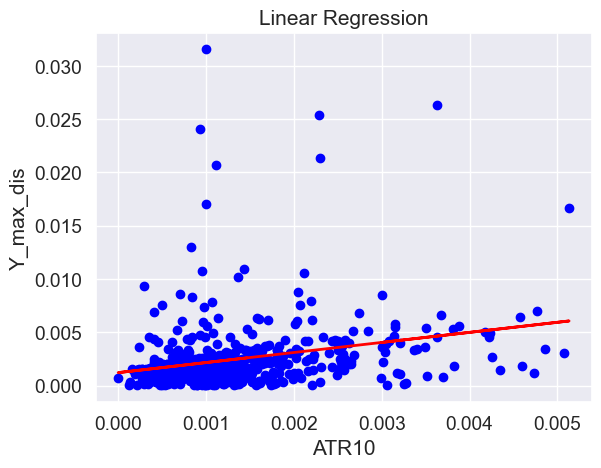

Y_min_dis:
rmse: 0.001798039188317351
Y_min_dis = 0.0004527885972406881 + 0.8266662727036788 * ATR10



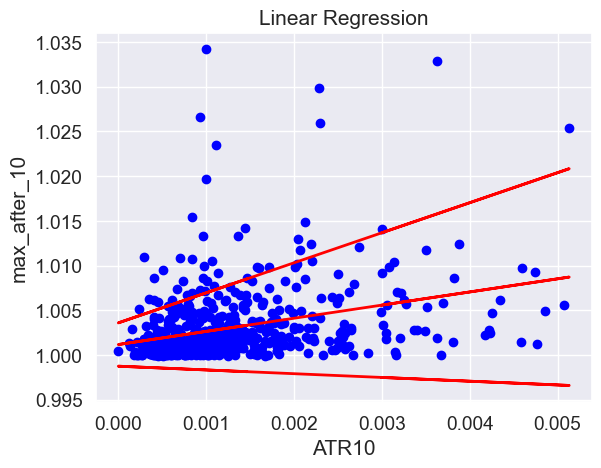

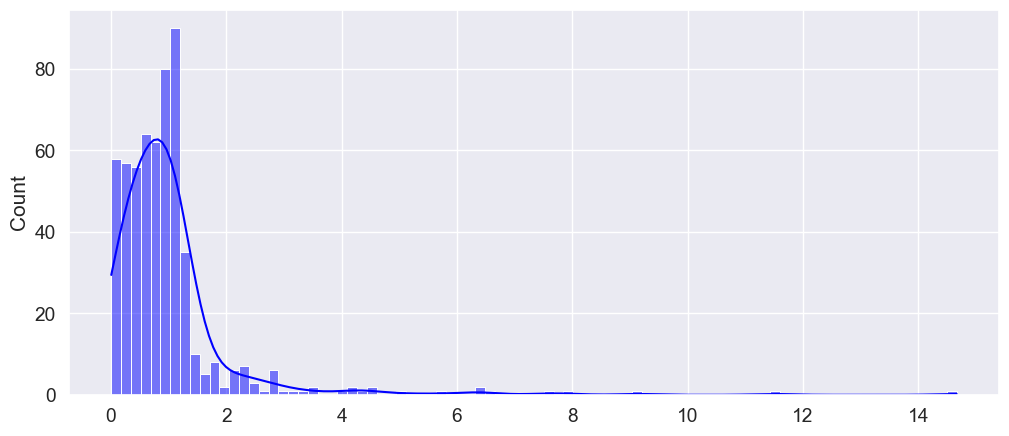

In [24]:
Y_max_dis = np.abs(Y_max - model_max.predict(X))
Y_min_dis = np.abs(Y_min - model_min.predict(X))
std_model_max = linear_regression(X, Y_max_dis, x_name, 'Y_max_dis', plot=True)
std_model_min = linear_regression(X, Y_min_dis, x_name, 'Y_min_dis')

plot_with_dis(model_max, std_model_max, X, Y_max, x_name, y_max_name, Y_max_dis)
# plot_with_dis(model_min, std_model_min, X, Y_min, x_name, y_min_name, Y_min_dis)

可以看到有很多点超过了 2 sigma，可以认为这些情况完全属于另一种情况。

即大部分突破并没有效果，短期走势依然处于随机游走状态，超过 2 sigma 则属于真正的突破，明显不是随机游走。

因此我们需要除去这部分点，然后重新对符合随机游走的点做线性回归

max:
0.9229422066549913
max_after_10:
rmse: 0.0020010837280895174
max_after_10 = 1.0007571398183366 + 1.1536499457006657 * ATR10

dis:
rmse: 0.001175607854939401
dis = 0.0006954201367866048 + 0.6535741678896724 * ATR10

min:
0.9229422066549913
min_after_10:
rmse: 0.001491228575001966
min_after_10 = 0.9997681978325317 + -1.419720422179505 * ATR10

dis:
rmse: 0.0008747793385368996
dis = 0.00023310840817385235 + 0.6536393829145217 * ATR10



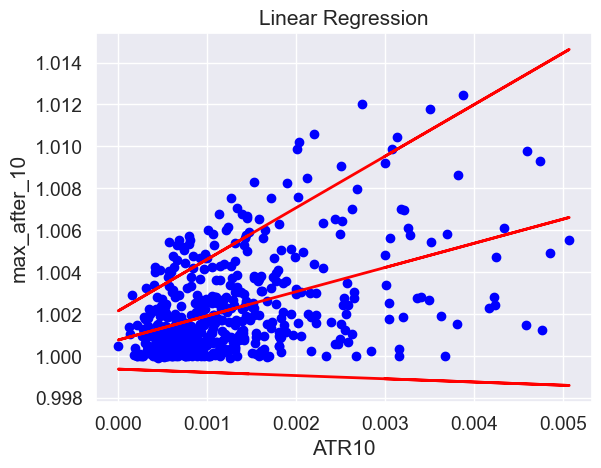

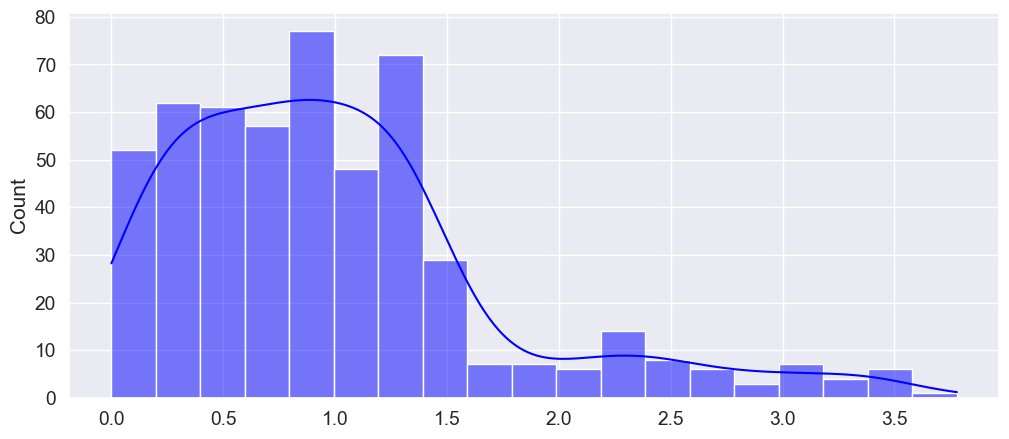

In [25]:
def train_again(model, std_model, X, Y, x_name, y_name):
    if 'max' in y_name:
        print('max:')
        valid = Y < model.predict(X) + 2 * std_model.predict(X)
    else:
        print('min:')
        valid = Y > model.predict(X) - 2 * std_model.predict(X)

    print(sum(valid) / len(valid))
    # 2 sigma 以内的数据已经包括了 92 % 的数据，对该数据重新做回归，保证模型不受 outlier 的影响
    X = X[valid]
    Y = Y[valid]
    model = linear_regression(X, Y, x_name, y_name)
    Y_dis = np.abs(Y - model.predict(X))
    std_model = linear_regression(X, Y_dis, x_name, 'dis')
    return model, std_model, valid

model_max, std_model_max, valid_max = train_again(model_max, std_model_max, X, Y_max, x_name, y_max_name)
model_min, std_model_min, valid_min = train_again(model_min, std_model_min, X, Y_min, x_name, y_min_name)

X_max = X[valid_max]
X_min = X[valid_min]
Y_max = Y_max[valid_max]
Y_min = Y_min[valid_min]

# New dis
Y_max_dis = np.abs(Y_max - model_max.predict(X_max))
Y_min_dis = np.abs(Y_min - model_min.predict(X_min))
plot_with_dis(model_max, std_model_max, X_max, Y_max, x_name, y_max_name, Y_max_dis)
# plot_with_dis(model_min, std_model_min, X_min, Y_min, x_name, y_min_name, Y_min_dis)

所以可以使用修正的模型，预测最高点和最低点，同时预测 std，当超多 2 std 时开始做空，超过 3 std 时开多。
开多后如何卖出或止损待考虑

#### 根据 max, min, imax, imain 绘制 K 线便于直观观察

In [26]:
def value_predict(model, std_model, atr10):
    x = np.array(atr10, ndmin=2)
    x = x.reshape(-1, 1)
    value = model.predict(x)
    dis = std_model.predict(x)
    
    if len(value) == 1:
        value = value[0]

    if len(dis) == 1:
        dis = dis[0]
    
    return value, dis

value_max, dis_max = value_predict(model_max, std_model_max, buy_break_data['ATR10'].iloc[10])
value_min, dis_min = value_predict(model_min, std_model_min, buy_break_data['ATR10'].iloc[10])
print(value_max, dis_max)
print(value_min, dis_min)

1.0036975414157836 0.002361237861196649
0.9961496407365408 0.001899092351430401


imax_first num: 340
Last top: 1.0001, Open: 0.9964, 
          value_max: 		1.0064, 	value_min: 		0.9929
          value_max + 2std: 	1.0141, 	value_min - 2std: 	0.9861
          actual_max: 		1.0049, 	actual_min: 		0.9859
          actual_max idx: 	0.0000, 	actual_min idx: 	7.0000


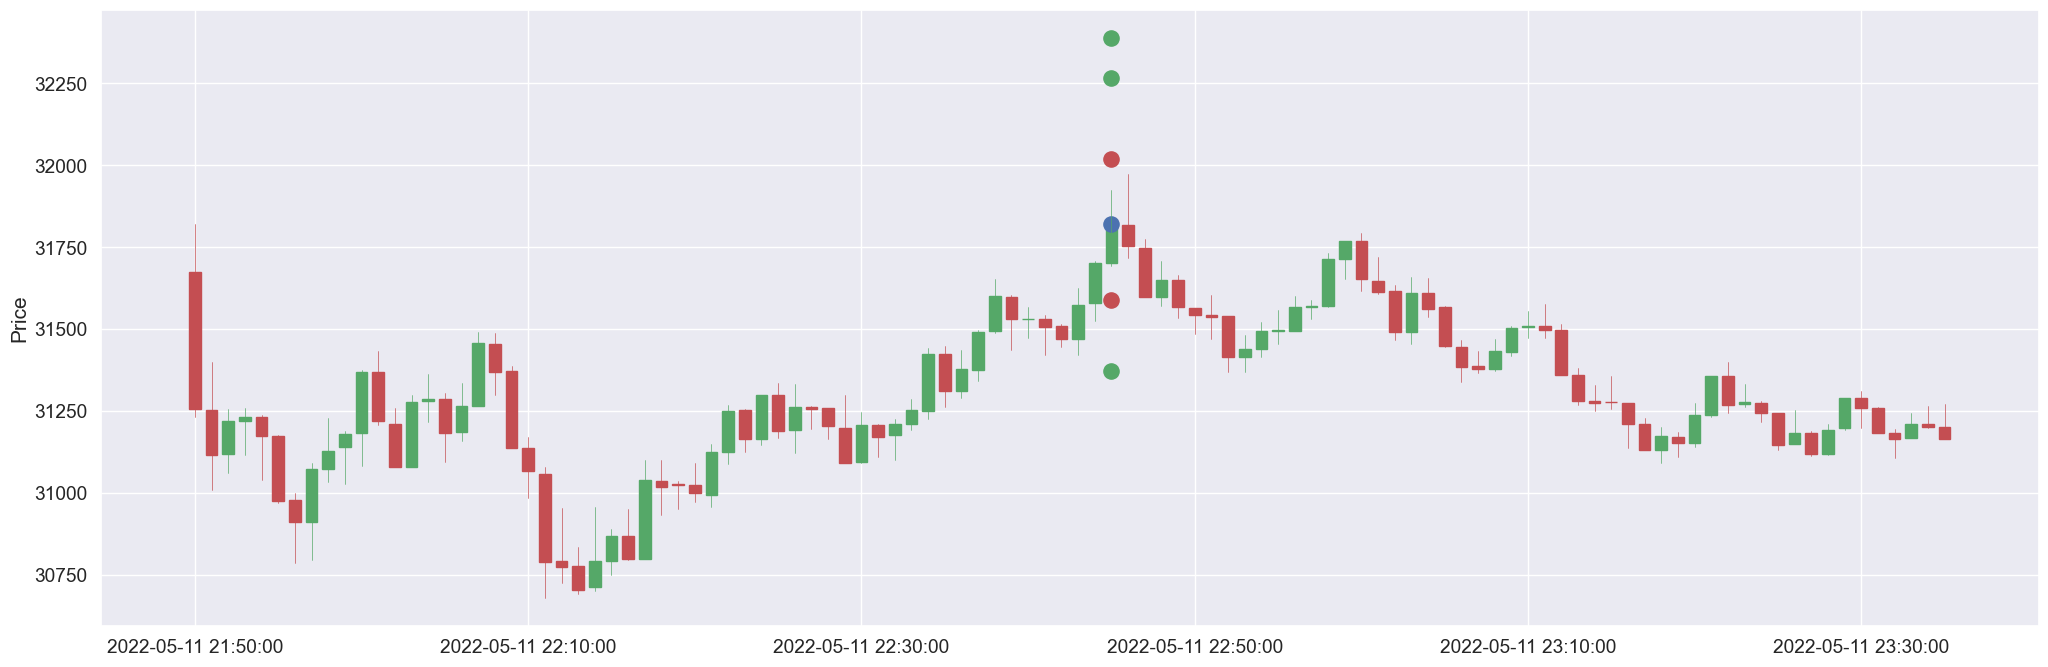

In [27]:
max_10 = buy_break_data[buy_break_data[max_win] > 1.02].index.to_list()
imax = buy_break_data[buy_break_data[imax_win] == 0].index.to_list()
imin = buy_break_data[buy_break_data[imin_win] == 0].index.to_list()

idx_max_first = (buy_break_data[imax_win] < buy_break_data[imin_win]) # & (buy_break_data[max_win] > 1.02)
idx_min_first = buy_break_data[imax_win] > buy_break_data[imin_win]
idx_max_min = buy_break_data[imax_win] == buy_break_data[imin_win]

imax_first = buy_break_data[idx_max_first].index.to_list()
imin_first = buy_break_data[idx_min_first].index.to_list()
imax_min = buy_break_data[idx_max_min].index.to_list()

print(f'imax_first num: {len(imax_first)}')
# start = buy_break_data.index.values[0]
start = imax_first[1]
last_top_idx = start - full_data.loc[start, 'step_after_top']

# Predict max value and dis
atr10 = buy_break_data.loc[start, 'ATR10']
value_max, dis_max = value_predict(model_max, std_model_max, atr10)
value_min, dis_min = value_predict(model_min, std_model_min, atr10)

close: float = full_data.loc[start, 'close'] # type: ignore
points = [PricePlot.Points(start, full_data.loc[start, 'last_top'], s=120, c='b', label='last_top'),
          PricePlot.Points(start, close * value_max, s=120, c='r', label=''),
          PricePlot.Points(start, close * (value_max + 2*dis_max), s=120, c='g', label=''),
          PricePlot.Points(start, close * (value_max + 3*dis_max), s=120, c='g', label=''),
          PricePlot.Points(start, close * value_min, s=120, c='r', label=''),
          PricePlot.Points(start, close * (value_min - 2*dis_min), s=120, c='g', label='')]

def d(name):
    return buy_break_data.loc[start, name]
print(f"""Last top: {d('last_top') :.4f}, Open: {d('open') :.4f}, 
          value_max: \t\t{value_max :.4f}, \tvalue_min: \t\t{value_min :.4f}
          value_max + 2std: \t{value_max + 2*dis_max :.4f}, \tvalue_min - 2std: \t{value_min - 2*dis_min :.4f}
          actual_max: \t\t{d(max_win) :.4f}, \tactual_min: \t\t{d(min_win) :.4f}
          actual_max idx: \t{d(imax_win) :.4f}, \tactual_min idx: \t{d(imin_win) :.4f}""")
plot(full_data, last_top_idx, start+50, points)

#### 制定策略，统计信息

1. 先高后低，和先低后高的数量

In [28]:
# 统计信息
idx_max_first = buy_break_data[imax_win] < buy_break_data[imin_win]
idx_min_first = buy_break_data[imax_win] > buy_break_data[imin_win]
idx_max_min = buy_break_data[imax_win] == buy_break_data[imin_win]
# print(sum(idx_max_min))

total = len(buy_break_data)
print(f"max_first: {sum(idx_max_first) / total * 100 :.2f} %, min_first: {sum(idx_min_first) / total * 100 :.2f} %")
print(f"max_first earn: {buy_break_data[idx_max_first][target.target_name()].mean() * 100 :.2f} %,\
        min_first earn: {buy_break_data[idx_min_first][target.target_name()].mean() * 100 :.2f} %")

# Check result if min first or max first
# check_data = buy_break_data[idx_min_first]

# X = check_data['ATR10'].values.reshape(-1, 1)
# Y_min = check_data[min_win].values.reshape(-1, 1)
# Y_max = check_data[max_win].values.reshape(-1, 1)

# plot_with_dis(model_max, std_model_max, X, Y_max, x_name, y_max_name)
# plot_with_dis(model_min, std_model_min, X, Y_min, x_name, y_min_name)

max_first: 58.62 %, min_first: 39.83 %
max_first earn: -0.29 %,        min_first earn: 0.14 %


结论是突破高点后更多的情况时要下跌的。

选择稍高的地方直接做空（多高需要尝试），跌到 pred - 2*dis 平仓，或 10 个周期后平仓

如果突破 pred + 2*dis 止损（或直接做多，需考虑做多后怎么退出）

3


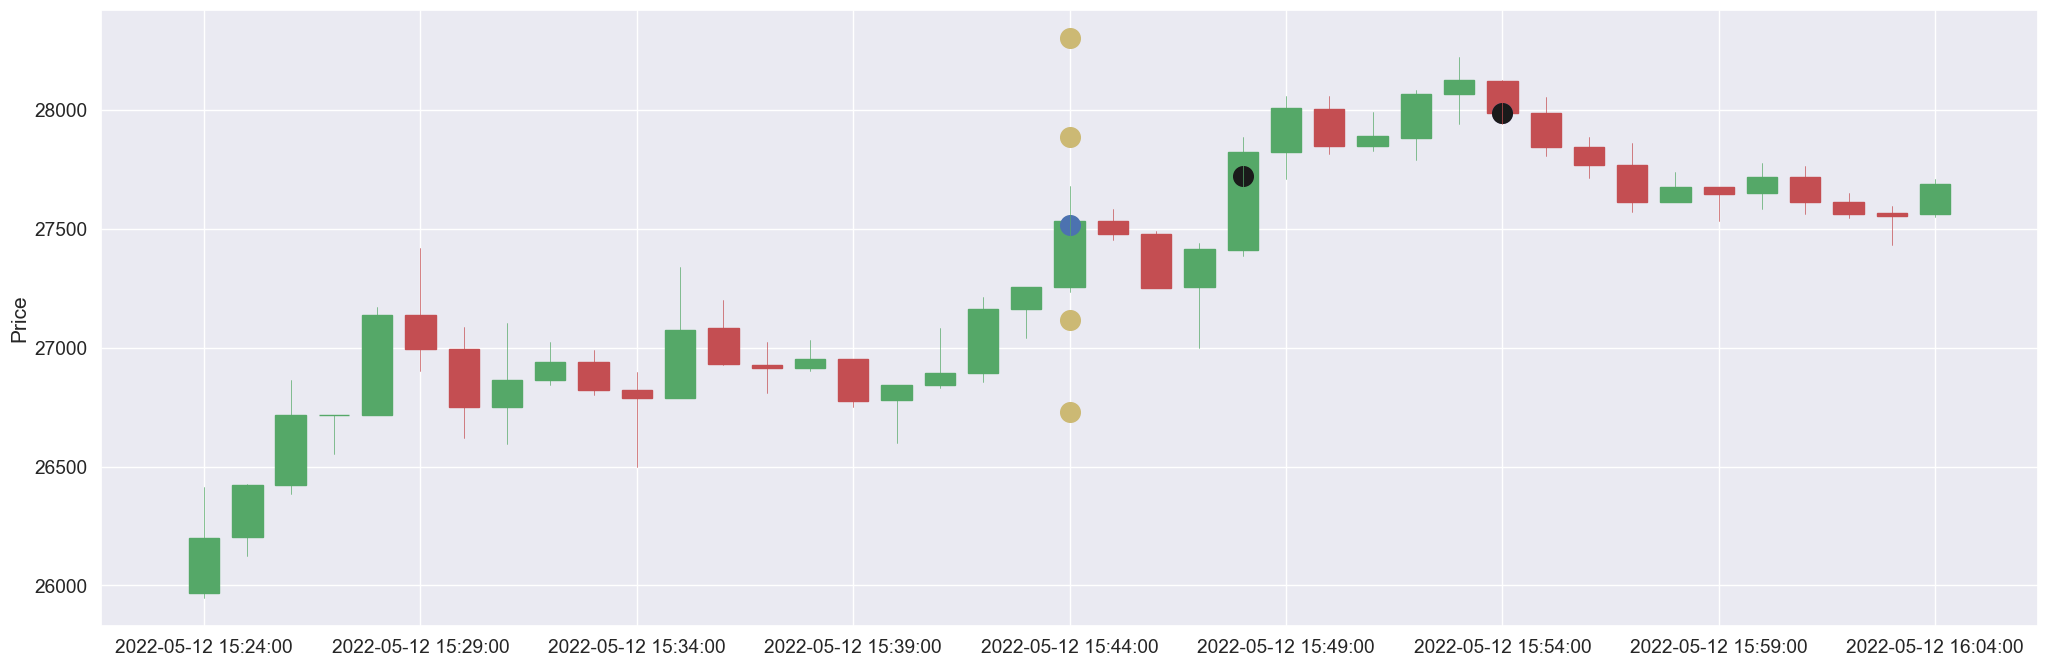

Trade num:          65
Stop num:           0
Trade percentage:   11.21 %
Trade num per day:  0.936
Total earn:         8.37 %
Average earn:       0.13 %



In [110]:
# for d_dis in np.arange(-2, 4.1, 0.5):
d_dis = 3
print(d_dis)
trade_data = buy_break_data.copy()

atr10 = trade_data['ATR10']
max_pred, dis_max = value_predict(model_max, std_model_max, atr10)
min_pred, dis_min = value_predict(model_min, std_model_min, atr10)
temp_df = pd.DataFrame({'max_pred': max_pred, 'dis_max': dis_max, 'min_pred': min_pred, 'dis_min': dis_min})
temp_df.index = trade_data.index
trade_data = pd.concat([trade_data, temp_df], axis=1)
trade_data['earn'] = 0
trade_data['reason'] = 'NoTrade'

trade_steps = 10
for i, idx in enumerate(trade_data.index):
    # Get price
    close = full_data.loc[idx, 'close']
    # sell_price = close * (max_pred[i] + d_dis*dis_max[i])  # 做空
    sell_price = close*1.0069  # 做空
    exit_price = close * (min_pred[i] - 100*dis_min[i])  # 退出
    stop_price = close * (max_pred[i] + 100*dis_max[i])  # 止损

    highs, lows, closes = full_data.loc[idx+1 : idx+trade_steps, ['high', 'low', 'close']].values.transpose()

    # 1. bought at the close
    # print(f"Sold at {close}")
    is_sold = False
    is_exited = False
    end_idx = 0
    sold_idx = 0
    log = False

    def sell_exit(price, exit_j, reason):
        global is_exited, idx, end_idx, trade_data
        is_exited = True
        end_idx = idx + 1 + exit_j
        earn = (sell_price - price) / sell_price

        trade_data.loc[idx, 'earn'] = earn
        trade_data.loc[idx, 'reason'] = reason
        if log:
            print(f"{idx}: {reason} at {price :.1f}, earn {earn * 100 :.2f} %")

    # Calculate earn at this break point
    assert(trade_steps == len(highs))
    for j in range(len(highs)):
        if is_sold:
            # 2. Whether stop
            if not is_exited:
                # Stop
                if highs[j] >= stop_price:
                    sell_exit(stop_price, j, 'Stop')
                # Exit
                elif lows[j] <= exit_price:
                    sell_exit(exit_price, j, 'Exit')
            else:
                break
        else:
            # Whether sell
            if highs[j] >= sell_price:
                is_sold = True
                sold_idx = idx + 1 + j

                # We may stop at the same step
                if highs[j] >= stop_price:
                    sell_exit(stop_price, j, 'Stop')
    
    # 3. Not stoped, exit at the close price at the end step
    if is_sold:
        if not is_exited:
            sell_exit(closes[-1], len(closes)-1, 'End')
    else:
        if log:
            print(f"{idx}: Not sold.")


    # plot
    if idx == 1873:
        points = [PricePlot.Points(idx, full_data.loc[idx, 'last_top'], s=200, c='b', label='last_top'),
                PricePlot.Points(idx, close * max_pred[i], s=200, c='y', label=''),
                PricePlot.Points(idx, close * (max_pred[i] + 2*dis_max[i]), s=200, c='y', label=''),
                PricePlot.Points(idx, close * min_pred[i], s=200, c='y', label=''),
                PricePlot.Points(idx, close * (min_pred[i] - 2*dis_min[i]), s=200, c='y', label=''),
                PricePlot.Points(idx+len(closes), closes[-1], s=200, c='m', label='End')]

        if is_sold:
            points += [
                PricePlot.Points(sold_idx, sell_price, s=200, c='k', label='Sold'),
                PricePlot.Points(end_idx, sell_price * (1-trade_data.loc[idx, 'earn']), s=200, c='k', label='Exit')] # type: ignore
        plot(full_data, idx-20, idx+20, points)

    # For debug
    # if i >= 10:
    #     break

is_trade_arr = trade_data['reason'] != 'NoTrade'
is_stop_arr = trade_data['reason'] == 'Stop'
trade_num = sum(is_trade_arr)
print(f"Trade num:          {trade_num}")
print(f"Stop num:           {sum(is_stop_arr)}")
print(f"Trade percentage:   {trade_num / len(trade_data) * 100:.2f} %")
print(f"Trade num per day:  {trade_num / (len(full_data) / (60 * 24))}")
print(f"Total earn:         {trade_data['earn'].sum() * 100:.2f} %")
print(f"Average earn:       {trade_data['earn'].sum() / trade_num * 100:.2f} %")
print()

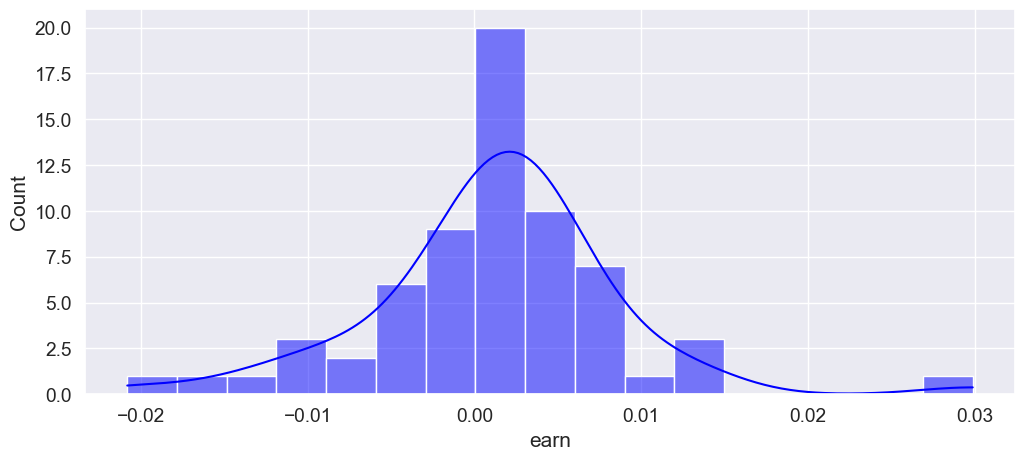

0.6439791961887281


In [111]:
trade_data['earn/dis'] = trade_data['earn'] / trade_data['dis_max']
# plt_box_A_B(trade_data, 'reason', 'earn', cut=False)
# plt_box_A_B(trade_data, 'reason', 'earn/dis', cut=False)

trade_idx = trade_data[is_trade_arr].index
# for idx in trade_idx:
#     print(f"{idx}: {milliseconds_to_date(full_data.loc[idx, 'open_time'])}")

histplot(trade_data.loc[trade_idx, 'earn'])
print(trade_data.loc[trade_idx, 'earn/dis'].mean())
# histplot(trade_data.loc[trade_idx, 'earn/dis'])


### 未来一段时间盈利的相关系数

In [23]:
heatmap_data = buy_break_data.copy()
target_step = 10
target.reset_target(target_step)

# base = 1
# target_name = f'{target_step}-{base}'
# heatmap_data[target_name] = heatmap_data[earn_name(target_step)] - heatmap_data[earn_name(base)]
# drop_other_steps(heatmap_data, base)

target_name = target.target_name()
target.drop_others(heatmap_data)
drop_col(heatmap_data, [max_win, min_win, imax_win, imin_win])
heatmap_font(heatmap_data, target=target_name)

In [ ]:
heatmap_data["index"] = heatmap_data.index
check_name, bias = ['histogram_TR', 0]
plt_A_B(heatmap_data, check_name, target_name)
plt_box_A_B(heatmap_data, check_name, target_name)
# heatmap_data[check_name+'_3cut'] = heatmap_data[check_name].apply(lambda x : 
#                                                             1 if x > 1.46e-5 else
#                                                             (-1 if x <-1.3e-6 else 0))
# plt_A_B(heatmap_data, check_name+'_3cut', target_name, cut=False)
# plt_box_A_B(heatmap_data, check_name+'_3cut', target_name, cut=False)
plt_A_B(heatmap_data, 'index', check_name, bias=bias)
plt_box_A_B(heatmap_data, 'index', check_name)
plt_A_B(heatmap_data, "index", target_name)

In [164]:
total_buy_bottom = len(buy_break_data)
for step in target.steps:
    print(f"{step}: earn rate: {sum(buy_break_data[target.name(step)] > 0) / total_buy_bottom * 100 :.2f} %, " + 
          f"mean of earn: {buy_break_data[target.name(step)].mean() * 100 :.2f}%")
    # histplot(buy_break_data[earn_name(step)])

1: earn rate: 47.07 %, mean of earn: 0.01%
3: earn rate: 41.21 %, mean of earn: -0.01%
5: earn rate: 43.10 %, mean of earn: -0.01%
10: earn rate: 42.93 %, mean of earn: -0.03%
30: earn rate: 45.69 %, mean of earn: -0.02%
100: earn rate: 46.55 %, mean of earn: -0.01%
300: earn rate: 46.72 %, mean of earn: -0.12%


In [ ]:
histplot(buy_break_data[target.name(300)])

# ML

## 获得训练集与测试集

In [ ]:
def split_data(full: pd.DataFrame, percentage=0.8, target_name='target'):
    # 特征列名
    category_col = [col for col in full if col != target_name]
    end_rows = int(full.shape[0] * percentage)

    x_train = full[category_col][:end_rows].values.astype(np.float64)
    y_train = full[target_name][:end_rows].values.astype(np.float64)

    x_test = full[category_col][end_rows:].values.astype(np.float64)
    y_test = full[target_name][end_rows:].values.astype(np.float64)

    return x_train, y_train, x_test, y_test

ML_data = buy_break_data.copy()
target.reset_target(10)
target.drop_others(ML_data)
x_train, y_train, x_test, y_test = split_data(ML_data, 0.5, target.target_name())

## xgb

In [ ]:
def xgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
                  'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
    else:
        xgb_params = params

    folds = KFold(n_splits=10, shuffle=True, random_state=2023)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if(verbose_eval):
            print("fold n°{}".format(fold_+1))
            print("len trn_idx  {}".format(len(trn_idx)))
            
        trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
        val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data,
                        num_boost_round=20000,
                        evals=watchlist,
                        early_stopping_rounds=200,
                        verbose_eval=verbose_eval,
                        params=xgb_params)
        
        
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
        predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.get_n_splits()

    if(verbose_eval):
        print("CV RMSE score: {:<8.8f}".format(sqrt(mean_squared_error(oof_xgb, y_train))))
    return oof_xgb, predictions_xgb

## lgb

In [ ]:
import lightgbm as lgb

def lgb_predict(X_train, y_train, X_test, params=None, verbose_eval=500):
    
    if params == None:
        lgb_param = {'num_leaves': 20, 'min_data_in_leaf': 2, 'objective':'regression', 'max_depth': 4,
         'learning_rate': 0.06, "min_child_samples": 2, "boosting": "gbdt", "feature_fraction": 1,
         "bagging_freq": 1, "bagging_fraction": 1, "bagging_seed": 11, "metric": 'rmse', "lambda_l2": 0.003,
         "verbosity": -1}
    else :
        lgb_param = params
        
    folds = KFold(n_splits=2, shuffle=True, random_state=2023)
    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if verbose_eval:
            print("fold n°{}".format(fold_+1))
            
        trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
        val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

        num_round = 50000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets = [trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds = 100)
        
        oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)

        predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.get_n_splits()

    if verbose_eval:
        print("CV RMSE score: {:<8.8f}".format(sqrt(mean_squared_error(oof_lgb, y_train))))
    
    return oof_lgb, predictions_lgb

In [ ]:
# 假设我们有一个训练数据集 X_train，一个测试数据集 X_test
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(x_train)
# X_test_scaled = scaler.transform(x_test)

oof, predictions = xgb_predict(x_train, y_train, x_test, verbose_eval=5000)

print("-"*100, end="\n\n")
print("CV normal RMSE scores of predicting {} \nis {:<8.8f}".
        format(ML_data.columns, sqrt(mean_squared_error(predictions, y_test))))

In [ ]:
print(np.std(y_test))
pred_std, pred_mean = [np.std(predictions), np.mean(predictions)]
print(pred_std)
print(pred_mean)

In [ ]:
histplot(predictions)

In [ ]:
buy_i = [i for i in range(len(y_test)) if predictions[i] > 0.0004] 
sell_i = [i for i in range(len(y_test)) if predictions[i] < -0.0004]
print(len(buy_i))
print(len(sell_i))

In [ ]:
check_idx = sell_i
# print(check_idx)
# print(y_test[check_idx])
sum(y_test[check_idx]) / len(y_test)

# 结果可视化

## 预测与实际结果对应关系

+ __画 A 与 B 的统计图__

In [ ]:
test_df = ML_data.iloc[len(y_train):, :].copy()
test_df["predict"] = predictions

# idx_A, idx_B, bias=0.0, cut=True, cut_num=50
plt_A_B(test_df, target.target_name(), 'predict', 0, cut_num=10)
plt_A_B(test_df, 'predict', target.target_name(), 0, cut_num=10)
# test_df.head()

In [ ]:
show_data_basic_info(test_df)

+ __画 A 与 B 的箱体图__

In [ ]:
def plt_box_A_B(df_data, idx_A, idx_B):
    plt.figure(figsize=(18,5))
    sns.boxplot(x=idx_A, y=idx_B, data=df_data)
    sns.stripplot(x=idx_A, y=idx_B, data=df_data)
    plt.title(idx_B)
    plt.show()


# plt_box_A_B(test_df, target_name + '_cut', 'predict')
plt_A_B(test_df, 'is_up', target_name)

## 预测与实际结果分布关系

In [ ]:
import seaborn as sns

def result_plot(pred, truth):
    plt.figure(figsize=(12,5))
    sns.histplot(pred, kde=True, color="blue")
    # plt.title("Predict")
    # plt.xlabel('yield', fontsize=12)

    # plt.show()
    # plt.figure(figsize=(12,5))
    sns.histplot(truth, kde=True, color="red")
    # plt.title("Ground truth")
    plt.show()
    
result_plot(predictions_xgb, y_test)

In [ ]:
l = sum(y_test>0.01)
print(l)
s = sum(y_test<-0.01)
print(s)
print((l+s) / len(y_test))